In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
DATA_DIR = Path("data/raw")
DATA_DIR

PosixPath('data/raw')

In [4]:
daily_dir = DATA_DIR / "daily_dataset"
files = sorted(daily_dir.glob("block_*.csv"))

len(files), files[:3]


(0, [])

In [5]:
from pathlib import Path

DATA_DIR = Path("../data/raw")
daily_dir = DATA_DIR / "daily_dataset"

print("DATA_DIR exists:", DATA_DIR.exists(), DATA_DIR.resolve())
print("daily_dir exists:", daily_dir.exists(), daily_dir.resolve())
print("daily_dir contents (first 20):")
print(sorted([p.name for p in daily_dir.iterdir()])[:20])

DATA_DIR exists: True /Users/robford/code/bertieford/forecast-and-flex/data/raw
daily_dir exists: False /Users/robford/code/bertieford/forecast-and-flex/data/raw/daily_dataset
daily_dir contents (first 20):


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/daily_dataset'

In [6]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

CWD: /Users/robford/code/bertieford/forecast-and-flex/notebooks


In [13]:
DATA_DIR = Path("../data/raw")
print("DATA_DIR exists:", DATA_DIR.exists(), DATA_DIR.resolve())
print("Top-level raw contents:", sorted([p.name for p in DATA_DIR.iterdir()])[:30])


DATA_DIR exists: True /Users/tanya/code/TSG18/forecast_and_flex/data/raw
Top-level raw contents: ['.DS_Store', '.gitkeep', 'acorn_details.csv', 'daily_dataset', 'daily_dataset.csv', 'darksky_parameters_documentation.html', 'halfhourly_dataset', 'hhblock_dataset', 'informations_households.csv', 'uk_bank_holidays.csv', 'weather_daily_darksky.csv', 'weather_hourly_darksky.csv']


In [14]:
daily_dir = DATA_DIR / "daily_dataset"
print("daily_dir exists:", daily_dir.exists(), daily_dir.resolve())

files = sorted(daily_dir.glob("*.csv"))
print("num csv files:", len(files))
print("first 10:", [f.name for f in files[:10]])


daily_dir exists: True /Users/tanya/code/TSG18/forecast_and_flex/data/raw/daily_dataset
num csv files: 0
first 10: []


In [16]:
print(sorted([p.name for p in daily_dir.iterdir()])[:50])

['daily_dataset']


In [17]:
files = sorted(daily_dir.rglob("*.csv"))
print("num csv files (recursive):", len(files))
print("first 10:", [f.name for f in files[:10]])
print("first 3 full paths:", [str(f) for f in files[:3]])


num csv files (recursive): 112
first 10: ['block_0.csv', 'block_1.csv', 'block_10.csv', 'block_100.csv', 'block_101.csv', 'block_102.csv', 'block_103.csv', 'block_104.csv', 'block_105.csv', 'block_106.csv']
first 3 full paths: ['../data/raw/daily_dataset/daily_dataset/block_0.csv', '../data/raw/daily_dataset/daily_dataset/block_1.csv', '../data/raw/daily_dataset/daily_dataset/block_10.csv']


In [18]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/raw")  # because notebook is in notebooks/
daily_dir = DATA_DIR / "daily_dataset" / "daily_dataset"

files = sorted(daily_dir.glob("block_*.csv"))
print("num block files:", len(files), "first 5:", [f.name for f in files[:5]])

N_BLOCKS = 5
daily = pd.concat((pd.read_csv(f) for f in files[:N_BLOCKS]), ignore_index=True)

daily.head()


num block files: 112 first 5: ['block_0.csv', 'block_1.csv', 'block_10.csv', 'block_100.csv', 'block_101.csv']


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087


In [19]:
import numpy as np

print(daily.columns)

# Common schema: LCLid, day, energy_sum
daily = daily.rename(columns={"day": "date", "energy_sum": "kwh"})

daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily["kwh"] = pd.to_numeric(daily["kwh"], errors="coerce")

daily = daily.dropna(subset=["LCLid", "date", "kwh"])
daily = daily[daily["kwh"] >= 0]

daily["weekday"] = daily["date"].dt.weekday
daily["month"] = daily["date"].dt.month
daily["is_weekend"] = (daily["weekday"] >= 5).astype(int)

daily.shape

Index(['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max',
       'energy_count', 'energy_std', 'energy_sum', 'energy_min'],
      dtype='object')


(151176, 12)

In [20]:
daily[["LCLid", "date", "kwh"]].head()
daily["LCLid"].nunique(), daily["date"].min(), daily["date"].max()


(250, Timestamp('2011-11-23 00:00:00'), Timestamp('2014-02-28 00:00:00'))

In [21]:
hh = daily.groupby("LCLid").agg(
    mean_daily_kwh=("kwh", "mean"),
    median_daily_kwh=("kwh", "median"),
    max_daily_kwh=("kwh", "max"),
    std_daily_kwh=("kwh", "std"),
    total_kwh=("kwh", "sum"),
    active_days=("kwh", "count"),
)

weekday_mean = daily[daily["is_weekend"] == 0].groupby("LCLid")["kwh"].mean()
weekend_mean = daily[daily["is_weekend"] == 1].groupby("LCLid")["kwh"].mean()

hh["weekday_mean"] = weekday_mean
hh["weekend_mean"] = weekend_mean
hh["weekend_ratio"] = hh["weekend_mean"] / hh["weekday_mean"]

winter_mean = daily[daily["month"].isin([12, 1, 2])].groupby("LCLid")["kwh"].mean()
summer_mean = daily[daily["month"].isin([6, 7, 8])].groupby("LCLid")["kwh"].mean()

hh["winter_mean"] = winter_mean
hh["summer_mean"] = summer_mean
hh["winter_summer_ratio"] = hh["winter_mean"] / hh["summer_mean"]

hh["load_variability"] = hh["std_daily_kwh"] / hh["mean_daily_kwh"]

hh = hh.replace([np.inf, -np.inf], np.nan).dropna()

hh.head(), hh.shape


(           mean_daily_kwh  median_daily_kwh  max_daily_kwh  std_daily_kwh  \
 LCLid                                                                       
 MAC000002       12.070638            11.214         39.284       4.494518   
 MAC000154        8.186767             8.323         19.463       2.587639   
 MAC000166        9.610762             9.561         27.122       2.305676   
 MAC000174       20.726764            20.366         45.019       4.167984   
 MAC000196        2.638857             2.401          7.058       1.333711   
 
               total_kwh  active_days  weekday_mean  weekend_mean  \
 LCLid                                                              
 MAC000002   6095.672001          505     11.758205     12.853889   
 MAC000154   4330.800000          529      8.063660      8.489307   
 MAC000166   7957.711000          828      9.587975      9.667924   
 MAC000174  17141.033998          827     20.349926     21.670458   
 MAC000196   2087.336000          791 

In [22]:
from sklearn.preprocessing import StandardScaler

X = hh.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

pca.explained_variance_ratio_


array([0.63945029, 0.11996791, 0.0829912 , 0.07229016, 0.0542363 ,
       0.01421412, 0.01020549, 0.00301288, 0.00181723, 0.0010276 ])

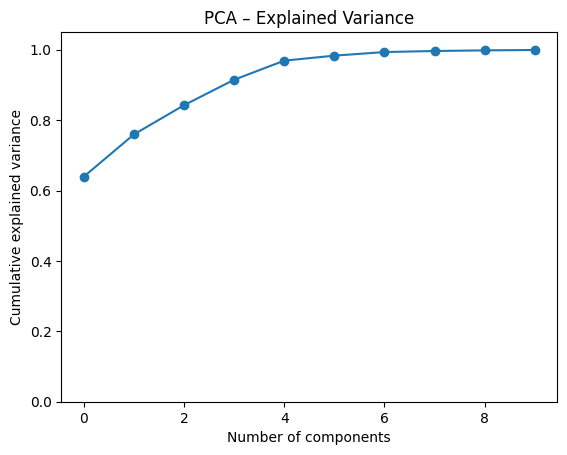

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Explained Variance")
plt.ylim(0, 1.05)
plt.show()


PC1 alone ≈ 64% of total variance

PC1 + PC2 ≈ ~75–80%

PC1–PC3 ≈ ~85%

PC1–PC4 ≈ ~90%

After ~4 PCs → diminishing returns

Most variation across households is driven by just 1–2 underlying factors.

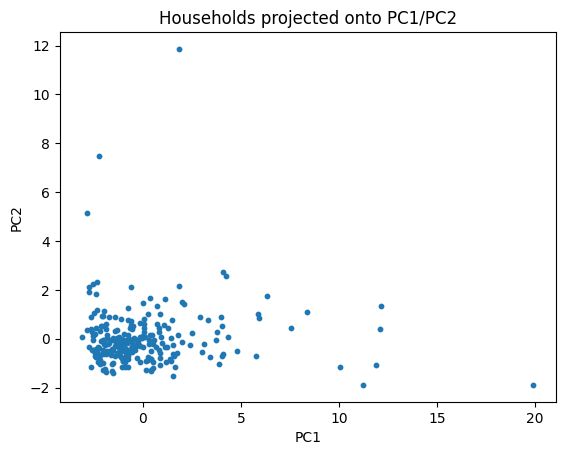

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Households projected onto PC1/PC2")
plt.show()


What this plot is

- Each dot = one household

- X = PC1 score
- Y = PC2 score
- No colouring → pure structural view

What you see

- A dense core around PC1 ≈ 0
- A long right-hand tail on PC1 (outliers up to ~20)
- PC2 spreads households vertically, but with less extreme outliers

Interpretation

- This shape tells you:

PC1 (horizontal)

- Dominated by scale of usage
- Households far right = very high energy consumers
- Long tail → a small number of households consume disproportionately more energy

PC2 (vertical)

- Captures behavioural differences  
- Separates households with:
-- stable vs volatile usage
-- seasonal vs flat consumption
-- weekday vs weekend skew

Important insight

- There are no discrete clusters, just a continuum.

This is realistic: energy behaviour varies smoothly, not in neat buckets.

In [26]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=hh.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings[["PC1", "PC2"]].sort_values("PC1", ascending=False)


,PC1,PC2
mean_daily_kwh,0.344923,-0.035130
weekday_mean,0.343754,-0.023623
weekend_mean,0.343104,-0.063152
winter_mean,0.338880,0.055837
median_daily_kwh,0.338475,-0.100689
total_kwh,0.336172,-0.053259
max_daily_kwh,0.321207,0.066242
summer_mean,0.318970,-0.160111
std_daily_kwh,0.309689,0.240044
winter_summer_ratio,0.035072,0.519801


PC1 loadings (dominant features)

Highest positive loadings:

- mean_daily_kwh
- weekday_mean
- weekend_mean
- winter_mean
- median_daily_kwh
- total_kwh
- max_daily_kwh

What PC1 means

PC1 ≈ “How much energy does this household use overall?”

Everything loading strongly on PC1 is a scale variable.

So:

- High PC1 = consistently high consumption
- Low PC1 = consistently low consumption

This is why PC1 explains ~64% of variance.

PC2 loadings (behavioural axis)

Strong contributors:

- load_variability (+0.67)
- winter_summer_ratio (+0.52)
- weekend_ratio (−0.37)
- std_daily_kwh (+0.24)
- active_days (−0.20)

What PC2 means

PC2 ≈ “How consumption varies across time and seasons”

Specifically:

High PC2:
-- spiky / variable usage
-- strong winter dominance
-- irregular consumption

Low PC2:
-- flatter profiles
-- stronger weekend usage
-- more consistent behaviour

Key takeaway

PC2 is orthogonal to PC1:
- Two households can use the same total energy
- But behave very differently over time

In [27]:
pd.read_csv(DATA_DIR / "informations_households.csv").columns


Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')

In [28]:
meta = pd.read_csv(DATA_DIR / "informations_households.csv")

# Keep only what we need
meta = meta[["LCLid", "stdorToU", "Acorn", "Acorn_grouped"]].drop_duplicates()

# Join to household feature table
analysis = hh.reset_index().merge(meta, on="LCLid", how="left").set_index("LCLid")

analysis.head()


,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,summer_mean,winter_summer_ratio,load_variability,stdorToU,Acorn,Acorn_grouped
LCLid,,,,,,,,,,,,,,,,
MAC000002,12.070638,11.214,39.284,4.494518,6095.672001,505,11.758205,12.853889,1.093185,13.203778,9.141011,1.444455,0.372351,Std,ACORN-A,Affluent
MAC000154,8.186767,8.323,19.463,2.587639,4330.800000,529,8.063660,8.489307,1.052786,8.379989,9.275750,0.903430,0.316076,Std,ACORN-Q,Adversity
MAC000166,9.610762,9.561,27.122,2.305676,7957.711000,828,9.587975,9.667924,1.008338,9.984542,8.662592,1.152604,0.239906,Std,ACORN-Q,Adversity
MAC000174,20.726764,20.366,45.019,4.167984,17141.033998,827,20.349926,21.670458,1.064891,20.609358,20.824348,0.989676,0.201092,Std,ACORN-Q,Adversity
MAC000196,2.638857,2.401,7.058,1.333711,2087.336000,791,2.632666,2.654431,1.008267,3.248724,1.617048,2.009046,0.505413,Std,ACORN-Q,Adversity


Households with large PC1 actually do have high mean/total usage

Households with high PC2 do have high variability or seasonal skew

This confirms PCA is not producing abstract artefacts — it reflects real behaviour.

In [30]:
analysis[["Acorn_grouped", "Acorn", "stdorToU"]].isna().mean()
analysis["Acorn_grouped"].value_counts(dropna=False).head(10)


Acorn_grouped
Affluent     148
Adversity    100
ACORN-         2
Name: count, dtype: int64

In [38]:
analysis["PC1"] = X_pca[:, 0]
analysis["PC2"] = X_pca[:, 1]
analysis[["PC1", "PC2", "Acorn_grouped"]]

,PC1,PC2,Acorn_grouped
LCLid,,,
MAC000002,-0.439338,0.028516,Affluent
MAC000154,-1.336437,-0.255263,Adversity
MAC000166,-1.021487,-0.919588,Adversity
MAC000174,1.520961,-1.538780,Adversity
MAC000196,-2.645078,0.385706,Adversity
...,...,...,...
MAC005280,0.500541,-0.954556,Affluent
MAC005324,0.158112,-1.293213,Affluent
MAC005349,-2.444788,-0.716816,Affluent


This table shows:

- Individual households

- Their position in PCA space

- Their ACORN group

Example insight:

- Some Adversity households have high PC1 → high consumption is not exclusive to affluence

- Some Affluent households sit near the origin → efficient or smaller homes

This already hints that:

- Socio-economic status influences energy use, but does not fully determine it.

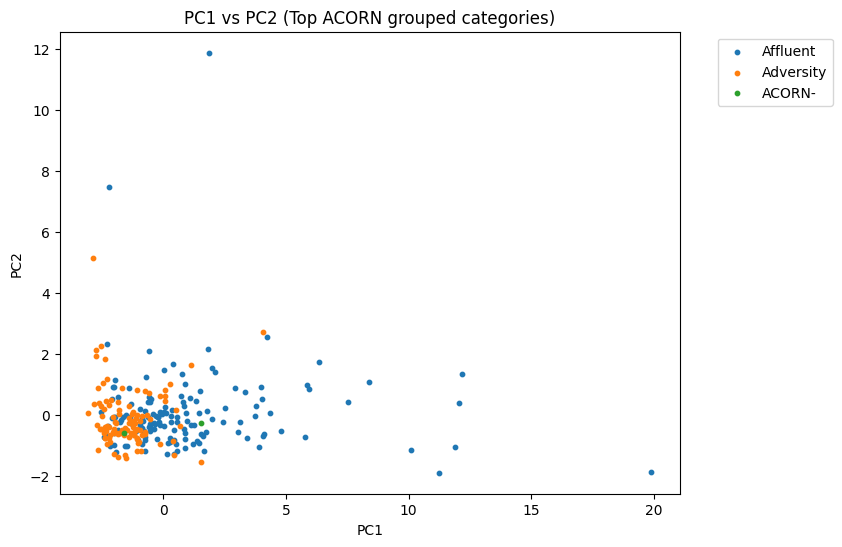

In [32]:
top_groups = analysis["Acorn_grouped"].value_counts().head(6).index
sub = analysis[analysis["Acorn_grouped"].isin(top_groups)].copy()

plt.figure(figsize=(8,6))
for g in top_groups:
    s = sub[sub["Acorn_grouped"] == g]
    plt.scatter(s["PC1"], s["PC2"], s=10, label=g)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 (Top ACORN grouped categories)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [34]:
analysis.groupby("Acorn_grouped")[["PC1", "PC2"]].mean().sort_values("PC1", ascending=False).head(10)


,PC1,PC2
Acorn_grouped,,
Affluent,0.980004,0.062110
ACORN-,-0.035780,-0.421421
Adversity,-1.449690,-0.083494


In [35]:
analysis.groupby("Acorn_grouped")[["PC1", "PC2"]].std().head(10)


,PC1,PC2
Acorn_grouped,,
ACORN-,2.201351,0.233111
Adversity,1.101843,0.979244
Affluent,3.300044,1.412493


In [36]:
def top_loadings(pc, n=5):
    s = loadings[pc].sort_values(key=np.abs, ascending=False).head(n)
    return s

top_loadings("PC1", 6), top_loadings("PC2", 6)


(mean_daily_kwh      0.344923
 weekday_mean        0.343754
 weekend_mean        0.343104
 winter_mean         0.338880
 median_daily_kwh    0.338475
 total_kwh           0.336172
 Name: PC1, dtype: float64,
 load_variability       0.669632
 winter_summer_ratio    0.519801
 weekend_ratio         -0.365843
 std_daily_kwh          0.240044
 active_days           -0.195041
 summer_mean           -0.160111
 Name: PC2, dtype: float64)

PC1 represents overall consumption level because it loads on mean/max/total kWh.

PC2 represents behavioural pattern/seasonality because it loads on weekend_ratio / variability / winter_summer_ratio.

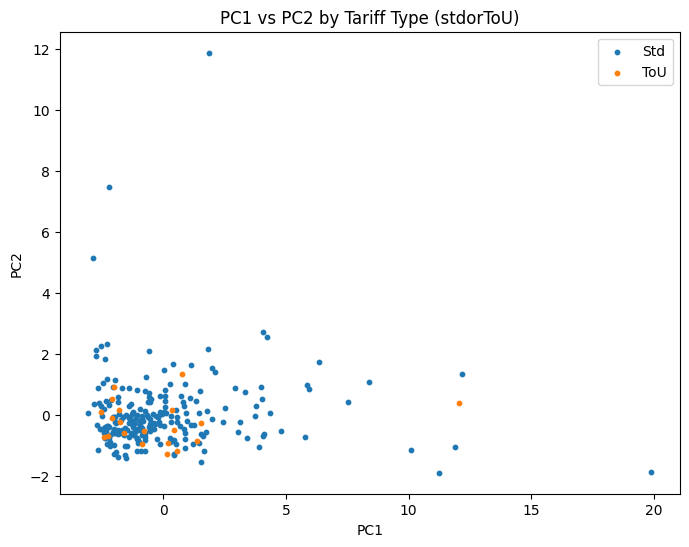

In [37]:
sub2 = analysis.dropna(subset=["stdorToU"])

plt.figure(figsize=(8,6))
for t in sub2["stdorToU"].unique():
    s = sub2[sub2["stdorToU"] == t]
    plt.scatter(s["PC1"], s["PC2"], s=10, label=t)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 by Tariff Type (stdorToU)")
plt.legend()
plt.show()


In [39]:
loadings[["PC3", "PC4"]].sort_values("PC3", key=np.abs, ascending=False).head(6)


,PC3,PC4
active_days,0.749006,-0.589670
weekend_ratio,0.447836,0.725109
winter_summer_ratio,0.395339,0.316511
std_daily_kwh,0.141025,0.026433
summer_mean,-0.137592,-0.002691
total_kwh,0.123137,-0.128142


Component	What it describes

PC1	How much electricity

PC2	How variable / seasonal

PC3	How regularly active

PC4	Weekend vs weekday lifestyle

What PC3 is really measuring

PC3 separates households by:

- How consistently they are active across the year

High PC3 households

- Active on many days

- Regular occupancy

- Likely primary residences

Steady lifestyles

- Low PC3 households

- Fewer active days

- Gaps in usage

Possible:

- holiday homes

- irregular occupancy

- people away often

Supporting features

- weekend_ratio (+0.45) → lifestyle pattern

- winter_summer_ratio (+0.39) → seasonal presence

- std_daily_kwh (+0.14) → minor variability

PC4 separates households by:

- When they use energy — weekends vs weekdays

High PC4 households

- Strong weekend-heavy usage

- Fewer active days overall

Could be:

- working households away weekdays

- second homes

- commuter lifestyles

Low PC4 households

- More weekday usage

- More consistent daily presence

- Possibly retirees / home-based lifestyles

In [44]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


In [45]:
analysis["PC1"] = X_pca[:, 0]
analysis["PC2"] = X_pca[:, 1]
analysis["PC3"] = X_pca[:, 2]
analysis["PC4"] = X_pca[:, 3]


In [46]:
analysis.columns


Index(['mean_daily_kwh', 'median_daily_kwh', 'max_daily_kwh', 'std_daily_kwh',
       'total_kwh', 'active_days', 'weekday_mean', 'weekend_mean',
       'weekend_ratio', 'winter_mean', 'summer_mean', 'winter_summer_ratio',
       'load_variability', 'stdorToU', 'Acorn', 'Acorn_grouped', 'PC1', 'PC2',
       'PC3', 'PC4'],
      dtype='object')

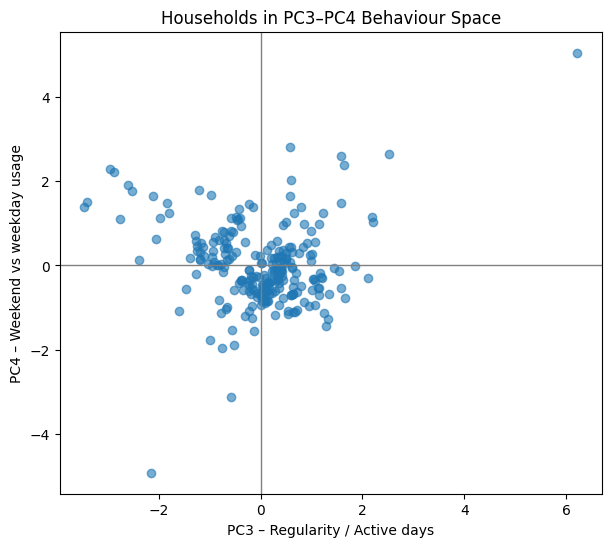

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(
    analysis["PC3"],
    analysis["PC4"],
    alpha=0.6
)

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)

plt.xlabel("PC3 – Regularity / Active days")
plt.ylabel("PC4 – Weekend vs weekday usage")
plt.title("Households in PC3–PC4 Behaviour Space")
plt.show()


In [48]:
analysis["weekend_type"] = pd.qcut(
    analysis["PC4"],
    q=3,
    labels=["Weekday-heavy", "Balanced", "Weekend-heavy"]
)

analysis["weekend_type"].value_counts()


weekend_type
Weekday-heavy    84
Weekend-heavy    84
Balanced         82
Name: count, dtype: int64

In [49]:
analysis.groupby("weekend_type")[[
    "mean_daily_kwh",
    "weekend_ratio",
    "weekday_mean",
    "std_daily_kwh"
]].mean()


/var/folders/3g/3ghy995d7p77qhc7cy6bg8x00000gn/T/ipykernel_31954/1158255059.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis.groupby("weekend_type")[[


,mean_daily_kwh,weekend_ratio,weekday_mean,std_daily_kwh
weekend_type,,,,
Weekday-heavy,15.010453,0.957657,15.193470,5.758029
Balanced,11.633686,1.043955,11.508489,4.517988
Weekend-heavy,14.997444,1.141678,14.460344,5.525848


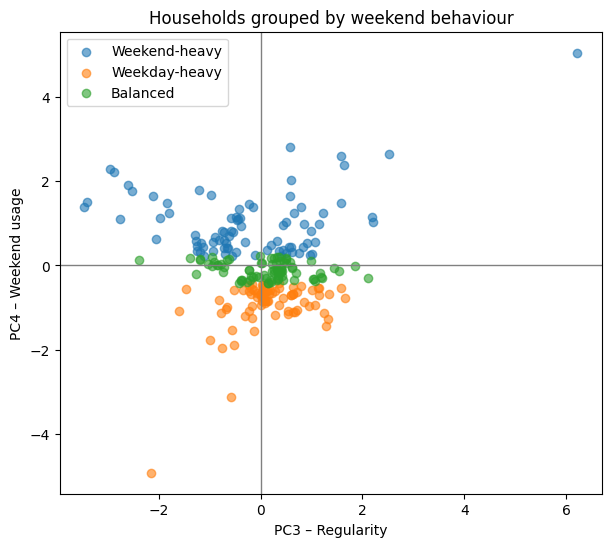

In [51]:
plt.figure(figsize=(7,6))

for label in analysis["weekend_segment"].unique():
    subset = analysis[analysis["weekend_segment"] == label]
    plt.scatter(
        subset["PC3"],
        subset["PC4"],
        label=label,
        alpha=0.6
    )

plt.axhline(0, color="grey", linewidth=1)
plt.axvline(0, color="grey", linewidth=1)

plt.xlabel("PC3 – Regularity")
plt.ylabel("PC4 – Weekend usage")
plt.title("Households grouped by weekend behaviour")
plt.legend()
plt.show()


In [52]:
analysis.groupby("weekend_segment")[[
    "mean_daily_kwh",
    "total_kwh",
    "std_daily_kwh",
    "weekend_ratio",
    "weekday_mean"
]].mean()


/var/folders/3g/3ghy995d7p77qhc7cy6bg8x00000gn/T/ipykernel_31954/722279086.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis.groupby("weekend_segment")[[


,mean_daily_kwh,total_kwh,std_daily_kwh,weekend_ratio,weekday_mean
weekend_segment,,,,,
Weekday-heavy,15.010453,10004.905119,5.758029,0.957657,15.193470
Balanced,11.633686,7122.912281,4.517988,1.043955,11.508489
Weekend-heavy,14.997444,7673.992333,5.525848,1.141678,14.460344


In [53]:
# Only if you haven't already
analysis["PC3"] = X_pca[:, 2]
analysis["PC4"] = X_pca[:, 3]


In [54]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_beh = analysis[["PC3", "PC4"]].dropna().values

scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_beh)
    scores[k] = silhouette_score(X_beh, labels)

scores


{2: 0.4255624690934686,
 3: 0.46566095786358463,
 4: 0.34425122392123136,
 5: 0.3745611828230386,
 6: 0.3785774571293972,
 7: 0.3844934460258609,
 8: 0.41184817626511305}

In [55]:
K = max(scores, key=scores.get)  # or manually set K=3
km = KMeans(n_clusters=K, random_state=42, n_init=10)

analysis = analysis.copy()
analysis["km_cluster"] = km.fit_predict(analysis[["PC3","PC4"]].values)
analysis["km_cluster"].value_counts()


km_cluster
2    164
0     67
1     19
Name: count, dtype: int64

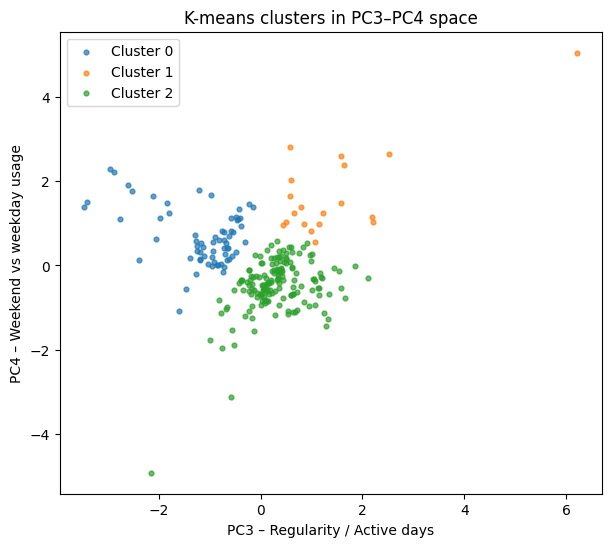

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for c in sorted(analysis["km_cluster"].unique()):
    sub = analysis[analysis["km_cluster"] == c]
    plt.scatter(sub["PC3"], sub["PC4"], s=12, alpha=0.7, label=f"Cluster {c}")
plt.xlabel("PC3 – Regularity / Active days")
plt.ylabel("PC4 – Weekend vs weekday usage")
plt.title("K-means clusters in PC3–PC4 space")
plt.legend()
plt.show()


In [57]:
cluster_profile = analysis.groupby("km_cluster")[[
    "active_days","weekend_ratio","winter_summer_ratio",
    "mean_daily_kwh","total_kwh","std_daily_kwh"
]].mean().sort_index()

cluster_profile


,active_days,weekend_ratio,winter_summer_ratio,mean_daily_kwh,total_kwh,std_daily_kwh
km_cluster,,,,,,
0,458.626866,1.030001,1.339744,16.371541,7562.439403,5.535288
1,618.684211,1.335145,3.943693,15.349730,9351.681420,7.458368
2,662.762195,1.021772,1.468275,12.720046,8443.541500,4.913094


In [58]:
ct = pd.crosstab(analysis["km_cluster"], analysis["stdorToU"], normalize="index")
ct


stdorToU,Std,ToU
km_cluster,,
0,0.955224,0.044776
1,0.947368,0.052632
2,0.902439,0.097561


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df_tar = analysis.dropna(subset=["stdorToU","PC3","PC4"]).copy()
y = (df_tar["stdorToU"] == "ToU").astype(int).values
X = df_tar[["PC3","PC4"]].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, ytr)

pred = clf.predict(Xte)
print("Accuracy:", accuracy_score(yte, pred))
print(classification_report(yte, pred))


Accuracy: 0.9206349206349206
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        58
           1       0.00      0.00      0.00         5

    accuracy                           0.92        63
   macro avg       0.46      0.50      0.48        63
weighted avg       0.85      0.92      0.88        63



/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanya/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [60]:
# daily must have: LCLid, kwh, is_weekend (0/1)
usage = daily.groupby(["LCLid","is_weekend"])["kwh"].sum().unstack(fill_value=0)
usage.columns = ["weekday_kwh","weekend_kwh"]  # assuming is_weekend 0 then 1
usage.head()


,weekday_kwh,weekend_kwh
LCLid,,
MAC000002,4244.712001,1850.960000
MAC000154,3031.936000,1298.864000
MAC000166,5676.081000,2281.630000
MAC000174,12026.806000,5114.227999
MAC000196,1490.089000,597.247000


In [61]:
analysis2 = analysis.join(usage, how="inner")
analysis2["total_kwh_check"] = analysis2["weekday_kwh"] + analysis2["weekend_kwh"]
analysis2.head()


,mean_daily_kwh,median_daily_kwh,max_daily_kwh,std_daily_kwh,total_kwh,active_days,weekday_mean,weekend_mean,weekend_ratio,winter_mean,...,PC1,PC2,PC3,PC4,weekend_type,weekend_segment,km_cluster,weekday_kwh,weekend_kwh,total_kwh_check
LCLid,,,,,,,,,,,,,,,,,,,,,
MAC000002,12.070638,11.214,39.284,4.494518,6095.672001,505,11.758205,12.853889,1.093185,13.203778,...,-0.439338,0.028516,-0.542689,0.790604,Weekend-heavy,Weekend-heavy,0,4244.712001,1850.960000,6095.672001
MAC000154,8.186767,8.323,19.463,2.587639,4330.800000,529,8.063660,8.489307,1.052786,8.379989,...,-1.336437,-0.255263,-0.670964,0.410034,Weekend-heavy,Weekend-heavy,0,3031.936000,1298.864000,4330.800000
MAC000166,9.610762,9.561,27.122,2.305676,7957.711000,828,9.587975,9.667924,1.008338,9.984542,...,-1.021487,-0.919588,1.274551,-1.437585,Weekday-heavy,Weekday-heavy,2,5676.081000,2281.630000,7957.711000
MAC000174,20.726764,20.366,45.019,4.167984,17141.033998,827,20.349926,21.670458,1.064891,20.609358,...,1.520961,-1.538780,1.320393,-1.259484,Weekday-heavy,Weekday-heavy,2,12026.806000,5114.227999,17141.033999
MAC000196,2.638857,2.401,7.058,1.333711,2087.336000,791,2.632666,2.654431,1.008267,3.248724,...,-2.645078,0.385706,1.242497,-1.132742,Weekday-heavy,Weekday-heavy,2,1490.089000,597.247000,2087.336000


In [62]:
analysis2["weekend_segment"] = pd.qcut(
    analysis2["PC4"], q=3, labels=["Weekday-heavy","Balanced","Weekend-heavy"]
)
analysis2["weekend_segment"].value_counts()


weekend_segment
Weekday-heavy    84
Weekend-heavy    84
Balanced         82
Name: count, dtype: int64

In [63]:
def revenue_neutral_weekday_price(df, discount=0.2, base=1.0):
    Wkday = df["weekday_kwh"].sum()
    Wkend = df["weekend_kwh"].sum()
    baseline = base * (Wkday + Wkend)
    weekend_price = base * (1 - discount)
    weekday_price = (baseline - weekend_price * Wkend) / Wkday
    return weekday_price, weekend_price

seg = analysis2[analysis2["weekend_segment"] == "Weekend-heavy"]
weekday_price, weekend_price = revenue_neutral_weekday_price(seg, discount=0.2, base=1.0)
weekday_price, weekend_price


(np.float64(1.0915773266714708), 0.8)

In [64]:
disc = 0.2
weekday_price, weekend_price = revenue_neutral_weekday_price(seg, discount=disc, base=1.0)

seg = seg.copy()
seg["bill_baseline"] = 1.0 * seg["total_kwh_check"]
seg["bill_new"] = weekday_price * seg["weekday_kwh"] + weekend_price * seg["weekend_kwh"]
seg["bill_delta"] = seg["bill_new"] - seg["bill_baseline"]

seg["bill_delta"].describe()


count    8.400000e+01
mean    -1.759439e-14
std      9.970172e+01
min     -7.122403e+02
25%     -1.204224e+01
50%      6.245341e+00
75%      2.965115e+01
max      2.184211e+02
Name: bill_delta, dtype: float64

In [65]:
(seg["bill_delta"] < 0).mean()


np.float64(0.40476190476190477)

In [66]:
analysis2["target_weekend_heavy"] = (analysis2["weekend_segment"] == "Weekend-heavy").astype(int)
analysis2["target_weekend_heavy"].value_counts()


target_weekend_heavy
0    166
1     84
Name: count, dtype: int64

In [67]:
N_DAYS = 30

d = daily.copy()
d = d.sort_values(["LCLid","date"])

# rank days per household
d["day_rank"] = d.groupby("LCLid")["date"].rank(method="dense").astype(int)

early = d[d["day_rank"] <= N_DAYS].copy()

early_feat = early.groupby("LCLid").agg(
    early_mean_kwh=("kwh","mean"),
    early_std_kwh=("kwh","std"),
    early_total_kwh=("kwh","sum"),
    early_active_days=("kwh","count"),
    early_weekend_mean=("kwh", lambda s: s[early.loc[s.index, "is_weekend"]==1].mean()),
    early_weekday_mean=("kwh", lambda s: s[early.loc[s.index, "is_weekend"]==0].mean()),
)
early_feat["early_weekend_ratio"] = early_feat["early_weekend_mean"] / early_feat["early_weekday_mean"]
early_feat = early_feat.replace([np.inf,-np.inf], np.nan).fillna(0)

early_feat.head()


,early_mean_kwh,early_std_kwh,early_total_kwh,early_active_days,early_weekend_mean,early_weekday_mean,early_weekend_ratio
LCLid,,,,,,,
MAC000002,13.440367,4.389093,403.211,30,16.088000,12.305667,1.307365
MAC000154,9.523633,3.518298,285.709,30,11.389444,8.724000,1.305530
MAC000166,7.036967,5.234201,211.109,30,6.999625,7.050545,0.992778
MAC000174,18.443700,4.027764,553.311,30,21.304111,17.217810,1.237330
MAC000196,4.465167,0.751627,133.955,30,4.309000,4.521955,0.952907


In [68]:
clf_df = analysis2[["target_weekend_heavy"]].join(early_feat, how="inner").dropna()
clf_df.shape


(250, 8)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = clf_df.drop(columns=["target_weekend_heavy"]).values
y = clf_df["target_weekend_heavy"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(Xtr, ytr)
proba = model.predict_proba(Xte)[:,1]
pred = (proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(yte, proba))
print("Accuracy:", accuracy_score(yte, pred))
print(classification_report(yte, pred))


AUC: 0.6870748299319728
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        42
           1       0.50      0.33      0.40        21

    accuracy                           0.67        63
   macro avg       0.61      0.58      0.58        63
weighted avg       0.64      0.67      0.65        63



In [70]:
threshold = np.quantile(proba, 0.8)
targeted = proba >= threshold
targeted.mean()


np.float64(0.20634920634920634)

In [75]:
analysis["Acorn_grouped"].value_counts()


Acorn_grouped
Affluent     148
Adversity    100
ACORN-         2
Name: count, dtype: int64

In [76]:
fair = analysis[analysis["Acorn_grouped"] != "ACORN-"].copy()


In [77]:
pd.crosstab(
    fair["Acorn_grouped"],
    fair["weekend_segment"],
    normalize="index"
)


weekend_segment,Weekday-heavy,Balanced,Weekend-heavy
Acorn_grouped,,,
Adversity,0.380000,0.360000,0.260000
Affluent,0.310811,0.310811,0.378378


In [78]:
pd.crosstab(
    fair["Acorn_grouped"],
    fair["km_cluster"],
    normalize="index"
)


km_cluster,0,1,2
Acorn_grouped,,,
Adversity,0.170000,0.070000,0.760000
Affluent,0.324324,0.081081,0.594595


Check the signifiance of bias with ACORN group is insignificant.

In [79]:
from scipy.stats import chi2_contingency

table = pd.crosstab(
    fair["Acorn_grouped"],
    fair["weekend_segment"]
)

chi2, p, _, _ = chi2_contingency(table)
chi2, p


(np.float64(3.809408293310733), np.float64(0.14886667881252325))

In [ ]:

# the signifiance of bias with ACORN group is insignificant.